HMM-DDM: Mouse Data
========================
In this notebook we will analyse a dataset of mice performing a two-alternative forced choice (TAFC) task developed in Kane, Senne, and Scott, 2025. mice performed this task daily in two-hour periods.

In [40]:
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using CSV
using DataFrames
using Dates
using Random
using Distributions
using LinearAlgebra
using StatsBase

ArgumentError: ArgumentError: Package StatsBase not found in current path.
- Run `import Pkg; Pkg.add("StatsBase")` to install the StatsBase package.

## Load and Preprocess the data

In [2]:
ddir = "../data/mouse_df.csv"
# load in the data
df = CSV.File(ddir) |> DataFrame;

In [3]:
# Group by animal name and count trials
trial_counts = combine(groupby(df, :name), nrow => :trial_count)

# Sort by count in descending order
sort!(trial_counts, :trial_count, rev=true)

# pick a mouse of interest (start with mouse of most trials)
moi = trial_counts[1, :name]

# get the data for the mouse of interest
mouse_df = df[df.name .== moi, :]

# get the RT and correct/incorrect chocies for said mouse. Map correct -> 1 and incorrect -> -1
outcomes = df[df.name .== moi, :outcome]
numeric_outcomes = [outcome == "correct" ? 1 : -1 for outcome in mouse_df.outcome]

# now RTs 
rts = df[df.name .== moi, :rt]

# Extract just the date part from the timestamp strings
dates = [Date(split(dt)[1]) for dt in mouse_df.trial_datetime]

# Get unique dates in chronological order
unique_dates = sort(unique(dates))

# Create a vector of vectors, where each inner vector contains DDMResults for one day
results_by_date = Vector{Vector{DDMResult}}()

for date in unique_dates
    # Get indices for this date
    day_indices = findall(dates .== date)
    
    # Extract RTs and outcomes for this date
    day_rts = rts[day_indices]
    day_outcomes = numeric_outcomes[day_indices]
    
    # Create DDMResult objects for this day
    day_results = [DDMResult(rt, choice) for (rt, choice) in zip(day_rts, day_outcomes)]
    
    # Add to our vector of vectors
    push!(results_by_date, day_results)
end

# Now calculate the sequence ends (cumulative sum of lengths)
seq_ends = cumsum([length(seq) for seq in results_by_date])

# Concatenate all results into a single vector
all_results = reduce(vcat, results_by_date)

12311-element Vector{DDMResult}:
 DDMResult(0.2716, 1)
 DDMResult(0.4124, -1)
 DDMResult(0.2669, 1)
 DDMResult(0.8428, 1)
 DDMResult(0.3541, 1)
 DDMResult(0.247, 1)
 DDMResult(0.4099, 1)
 DDMResult(0.2372, -1)
 DDMResult(0.3275, -1)
 DDMResult(0.2344, 1)
 ⋮
 DDMResult(0.4864, 1)
 DDMResult(0.2847, -1)
 DDMResult(0.2424, 1)
 DDMResult(0.4899, -1)
 DDMResult(0.226, -1)
 DDMResult(0.2562, -1)
 DDMResult(0.5747, 1)
 DDMResult(0.3208, 1)
 DDMResult(0.4196, 1)

# Visualize the correct and error RT distirbutions

In [25]:
correct_trials = [x for x in all_results if x.choice == 1]
incorrect_trials = [x for x in all_results if x.choice == -1]

4170-element Vector{DDMResult}:
 DDMResult(0.4124, -1)
 DDMResult(0.2372, -1)
 DDMResult(0.3275, -1)
 DDMResult(0.3141, -1)
 DDMResult(0.2789, -1)
 DDMResult(0.2179, -1)
 DDMResult(0.3106, -1)
 DDMResult(0.316, -1)
 DDMResult(0.3431, -1)
 DDMResult(0.1857, -1)
 ⋮
 DDMResult(0.4286, -1)
 DDMResult(0.273, -1)
 DDMResult(0.3582, -1)
 DDMResult(0.3204, -1)
 DDMResult(0.3076, -1)
 DDMResult(0.2847, -1)
 DDMResult(0.4899, -1)
 DDMResult(0.226, -1)
 DDMResult(0.2562, -1)

In [32]:
rt_dist_plot = histogram([x.rt for x in correct_trials], bins=100, alpha=0.5, label="Correct", legend=:topright)
incorrect_rts = [x.rt for x in incorrect_trials]
e, h = hist(incorrect_rts, bins=100)
# Adjust y-axis to make room for the downward bars
ylims!(minimum([-h.weights; 0]) * 1.1, maximum(h.weights) * 1.1)

UndefVarError: UndefVarError: `hist` not defined

## Perform Cross Validation

For these CV procedure we will do the following procedure:

- Shuffle the data across sessions
- Split the data into 5 folds
- For each numbert of states K in [2, 3, 4, 5]
    - For each fold
        - For 10 itemouseions
            - Randomly initialize the model parameters
            - Fit the model to the training data
            - Evaluate the model on the test data
            - Store the model parameters and performance metrics
        - Store the best model parameters and performance metrics
        - Compute the mean and standard deviation of the performance metrics across itemouseions

- Refit the best model of the selected K states to the entire dataset

In [4]:
cv_results, nobs = crossvalidate(results_by_date; n_states=2, n_folds=3, n_iter=3)

┌ Info: ⇢ evaluating 1 hidden state(s)
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:50
┌ Info: ⇢ evaluating 2 hidden state(s)
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:50
┌ Warning: Baum–Welch failed for n=2, iter=1, fold=2 ⇒ AssertionError("isfinite(phi_c) && isfinite(dphi_c)")
└ @ DriftDiffusionModels \Users\ryansenne\Documents\GitHub\DriftDiffusionModels.jl\src\Utilities.jl:84


(ll = Dict(2 => [-2003.8764623658608 -Inf -1352.5301977336317; -1328.3692542211718 -917.9565743632822 -1358.6734322059815; -1328.3766770988977 -1183.5953671643617 -1703.346404207264], 1 => [-2073.4680624106763 -1972.869690425891 -2229.420707894092; -2073.468062410403 -1972.8696904261983 -2229.420707894026; -2073.4680624105717 -1972.8696904258907 -2229.4207078939207]), nobs = [4001 4135 4175; 4001 4135 4175; 4001 4135 4175])

In [6]:
function calculate_ll_ratio(ℓℓ::Float64, ℓℓ₀::Float64, n::Int)
    ll_mouseio = ℓℓ - ℓℓ₀
    return ll_mouseio / (n * log(2))
end

calculate_ll_ratio (generic function with 1 method)

In [7]:
mean(calculate_ll_ratio.( cv_results[2], cv_results[1], nobs ), dims=1)

1×3 Matrix{Float64}:
 0.187477  -Inf  0.261898

In [8]:
plot(xlabel="k", ylabel="loglikelihood")
for i in 1:5
    scatter!([i for _ in 1:5], cv_results[i])
end
display(current())

ErrorException: Expects 5 elements in each col of y, found 3.

In [12]:
# generate a HMM to start from
trans_guess = [0.5 0.5; 0.5 0.5]
init_guess = [0.99, 0.01]

ddm_1_guess = DriftDiffusionModel(10, 1, 0.5, 1)
ddm_2_guess = DriftDiffusionModel(1, 0.1, 0.5, 1)

dists_guess = [ddm_1_guess, ddm_2_guess]

# create a prior distirbution for the initial states and transition matrix (sticky HMM)
α₀ = ones(2)
αₜ = ones(2, 2) .* 3
# αₜ[diagind(αₜ)] .= 2

hmm = PriorHMM(init_guess, trans_guess, dists_guess, αₜ, α₀)

hmm_est, lls = baum_welch(hmm, all_results; seq_ends=seq_ends)

(PriorHMM{Float64, DriftDiffusionModel}([5.1282274005864934e-55, 1.0], [0.25549330295081346 0.7445066970491865; 0.009444159038707671 0.9905558409612923], DriftDiffusionModel[DriftDiffusionModel(3.839118466407254, 0.14225538015510406, 0.18561331745469437, 1.0), DriftDiffusionModel(1.4259566762226896, 0.925465667548352, 0.4079408549164634, 1.0)], [3.0 3.0; 3.0 3.0], [1.0, 1.0]), [-18347.791001616108, -6125.9989916032855, -6067.202906439994, -6058.850209939495, -6057.15331381393, -6056.765543622248, -6056.6573710435105, -6056.596839414646, -6056.524403322848, -6056.413786950117  …  -6037.39737353155, -6037.397225843571, -6037.397123388755, -6037.397052284618, -6037.397002921414, -6037.396968641992, -6037.396944831678, -6037.396928289942, -6037.39691679604, -6037.396908808503])

## Confirm the LL converges!

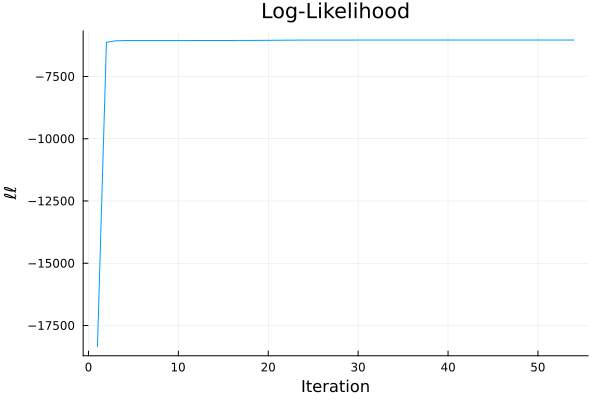

In [13]:
plot(lls, title="Log-Likelihood", xlabel="Iteration", ylabel="ℓℓ", legend=false)

## Plot the Posterior Distribution of the States


In [14]:
# get the posterior distribution of the hidden states
posterior = forward(hmm_est, all_results; seq_ends=seq_ends)
γ = posterior[1]

2×12311 Matrix{Float64}:
 8.67992e-62  0.0173874  1.75104e-9  …  2.18876e-5  2.14701e-8  6.43118e-7
 1.0          0.982613   1.0            0.999978    1.0         0.999999

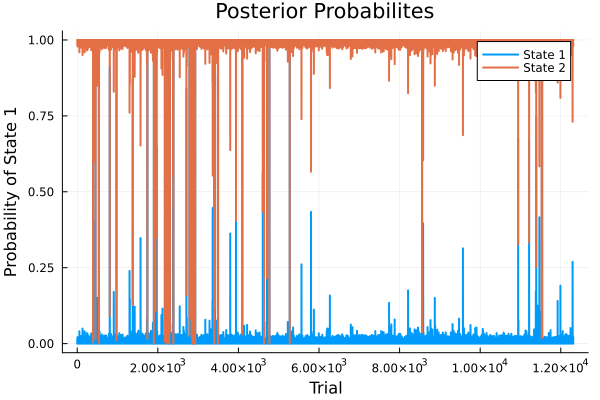

In [24]:
plot(γ[1, :], title="Posterior Probabilites", xlabel="Trial", ylabel="Probability of State 1", label="State 1", linewidth=2)
plot!(γ[2, :], label="State 2", linewidth=2)